In [1]:
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model

In [21]:
#!/usr/bin/env python3
"""
Full Set Transformer script using a custom AggregationLayer.
"""

import tensorflow as tf
from tensorflow.keras import layers

# --- 1) Dynamic tanh activation in place of LayerNorm ---
class DynamicTanh(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.math.tanh(inputs)

# --- 2) MAB: Multihead Attention Block ---
class MAB(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        super().__init__(**kwargs)
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.mha = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model // num_heads,
            output_shape=d_model
        )
        self.ffn = tf.keras.Sequential([
            layers.Dense(d_model, activation='relu'),
            layers.Dense(d_model)
        ])
        self.act = DynamicTanh()

    def call(self, Q, K):
        # Q: (batch, q_len, d_model)
        # K: (batch, k_len, d_model)  – also used as V
        H = self.mha(query=Q, value=K, key=K)   # (batch, q_len, d_model)
        H = self.act(Q + H)                     # residual + DynamicTanh
        H2 = self.ffn(H)
        return self.act(H + H2)                 # second residual + DynamicTanh

# --- 3) ISAB: Induced Set Attention Block ---
class ISAB(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, num_inducing, **kwargs):
        super().__init__(**kwargs)
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.num_inducing = num_inducing
        # learnable inducing points
        self.I = self.add_weight(
            shape=(1, num_inducing, d_model),
            initializer='glorot_uniform',
            trainable=True,
            name="inducing_points"
        )
        self.mab1 = MAB(d_model, num_heads)
        self.mab2 = MAB(d_model, num_heads)

    def call(self, X):
        # X: (batch, N, d_model)
        batch_size = tf.shape(X)[0]
        # tile inducing points to batch size
        I = tf.tile(self.I, [batch_size, 1, 1])  # (batch, num_inducing, d_model)
        H = self.mab1(I, X)                      # inducing attends to X
        return self.mab2(X, H)                   # X attends to induced H

# --- 4) Custom Aggregation Layer ---
class AggregationLayer(tf.keras.layers.Layer):
    """
    Aggregates a set of features over the sequence dimension.
    Supported aggregations: "mean" or "max".
    """
    def __init__(self, aggreg="mean", **kwargs):
        super().__init__(**kwargs)
        if aggreg not in ("mean", "max"):
            raise ValueError("Use 'mean' or 'max'")
        self.aggreg = aggreg

    def call(self, inputs):
        # inputs: (batch, N, d_model)
        if self.aggreg == "mean":
            return tf.reduce_mean(inputs, axis=1)  # (batch, d_model)
        else:  # "max"
            return tf.reduce_max(inputs, axis=1)   # (batch, d_model)

# --- 5) Build Set Transformer with custom aggregation ---
def build_set_transformer_with_agg(
    num_elements,
    feature_dim,
    d_model=64,
    num_heads=4,
    num_inducing=16,
    num_classes=5,
    aggregation="mean"
):
    """
    - num_elements: size of your set (e.g. number of particles)
    - feature_dim: input feature size (e.g. 3 for [pt, eta, phi])
    - d_model: hidden dimension
    - num_heads: attention heads
    - num_inducing: number of inducing points in ISAB
    - num_classes: number of target classes
    - aggregation: "mean" or "max"
    """
    inputs = layers.Input(shape=(num_elements, feature_dim))   # (batch, N, F)
    # initial linear embedding
    X = layers.Dense(d_model, activation='relu')(inputs)       # (batch, N, d_model)

    # stack of ISABs (you can vary the depth)
    X = ISAB(d_model, num_heads, num_inducing)(X)              # (batch, N, d_model)
    # ... add more ISAB layers if desired ...

    # custom aggregation over the set
    P = AggregationLayer(aggreg=aggregation)(X)                # (batch, d_model)

    # classification head
    H = layers.Dense(d_model, activation='relu')(P)            # (batch, d_model)
    outputs = layers.Dense(num_classes, activation='softmax')(H)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# --- 6) Example usage ---
if __name__ == "__main__":
    # parameters
    num_particles = 32
    feature_dim = 3    # e.g. [pt, eta, phi]
    d_model = 16
    num_heads = 4
    num_inducing = 4
    num_classes = 5

    # build and summarize
    model = build_set_transformer_with_agg(
        num_elements=num_particles,
        feature_dim=feature_dim,
        d_model=d_model,
        num_heads=num_heads,
        num_inducing=num_inducing,
        num_classes=num_classes,
        aggregation="max"  # or "mean"
    )
    model.summary()

    # (Optional) compile and test with dummy data
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    print("Output shape:", preds.shape)


Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)     │ (None, 32, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 32, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ isab_11 (ISAB)                  │ (None, 32, 16)         │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aggregation_layer_6             │ (None, 16)             │             0 │
│ (AggregationLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,749 (14.64 KB)

 Trainable params: 3,749 (14.64 KB)

 Non-trainable params: 0 (0.00 B)

Output shape: (8, 5)


In [22]:
from sklearn.model_selection import train_test_split


In [25]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=250, 
    batch_size=1024)

Epoch 1/250
485/485 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4450 - loss: 1.3147 - val_accuracy: 0.6096 - val_loss: 1.0067
Epoch 2/250
485/485 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.6195 - loss: 0.9873 - val_accuracy: 0.6605 - val_loss: 0.9194
Epoch 3/250
485/485 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.6749 - loss: 0.8939 - val_accuracy: 0.6972 - val_loss: 0.8480
Epoch 4/250
485/485 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.7009 - loss: 0.8388 - val_accuracy: 0.7118 - val_loss: 0.8125
Epoch 5/250
485/485 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.7153 - loss: 0.8043 - val_accuracy: 0.7210 - val_loss: 0.7830
Epoch 6/250
485/485 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.7272 - loss: 0.7704 - val_accuracy: 0.7287 - val_loss: 0.7556
Epoch 7/250
485/485 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.7366 - loss: 0.7387 - val_accuracy: 0.7457 - val_loss: 0.7148
Epoch 8/250
485/485 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.7471 - loss: 0

KeyboardInterrupt: 

In [38]:
out, attention = model(x_train[0].reshape(1,32,3))

In [11]:
import matplotlib.pyplot as plt

In [36]:
model.save_weights('noPairs32.weights.h5')

In [24]:
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph
import time
import numpy as np

def get_flops(model, input_shape):
    input_tensor = tf.TensorSpec(input_shape, tf.float32)
    concrete_func = tf.function(model).get_concrete_function(input_tensor)
    
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func)
    
    with tf.Graph().as_default() as graph:
        tf.compat.v1.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)
        return flops.total_float_ops


input_shape = [1] + list(x_val.shape[1:])
total_flops = get_flops(model, input_shape)
print("Total FLOPs for a single inference:", total_flops)

# ---------------------------
# Time Inference Per Event
# ---------------------------
import numpy as np
import time

_ = model(x_val[:10000])

num_trials = 100
inference_times = []
for _ in range(num_trials):
    start_time = time.perf_counter()
    _ = model(x_val[:10000])
    end_time = time.perf_counter()
    inference_times.append(end_time - start_time)

avg_inference_time_seconds = np.mean(np.array(inference_times) / 10000)
avg_inference_time_nanoseconds = avg_inference_time_seconds * 1e9

print("Average inference time per event:", np.round(avg_inference_time_nanoseconds,3), "nanoseconds")



2025-04-10 13:28:56.881480: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2025-04-10 13:28:56.881535: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-04-10 13:28:56.881666: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-10 13:28:56.881682: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Total FLOPs for a single inference:
=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Pl

In [30]:
x_val = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/x_val_robust_32const_ptetaphi.npy")
y_val = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/y_val_robust_32const_ptetaphi.npy")

In [31]:
xout = np.argmax(model(x_val, training=False),1)
yout = np.argmax(y_val,1)

In [32]:
import sklearn
sklearn.metrics.accuracy_score(xout,yout)

0.786923076923077

In [35]:
import matplotlib.pyplot as plt

# Suppose you have already trained your model:
# history = model.fit(...)

# Plotting the training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# If you also have accuracy or other metrics, you can plot them similarly:
if 'accuracy' in history.history:
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()


NameError: name 'history' is not defined

<Figure size 800x600 with 0 Axes>

1/FPR at TPR=80% for each class:
g: 1/FPR = 9.162959039548022
q: 1/FPR = 8.494081401005351
W: 1/FPR = 36.252835456290356
Z: 1/FPR = 48.2354853692522
t: 1/FPR = 25.605555555555554
Average 1/FPR across classes: 25.550183364330298

Accuracy at the threshold corresponding to TPR=80% for each class:
g: accuracy = 0.8725
q: accuracy = 0.8663
W: accuracy = 0.9378
Z: accuracy = 0.9432
t: accuracy = 0.9284
Average accuracy across classes: 0.9096


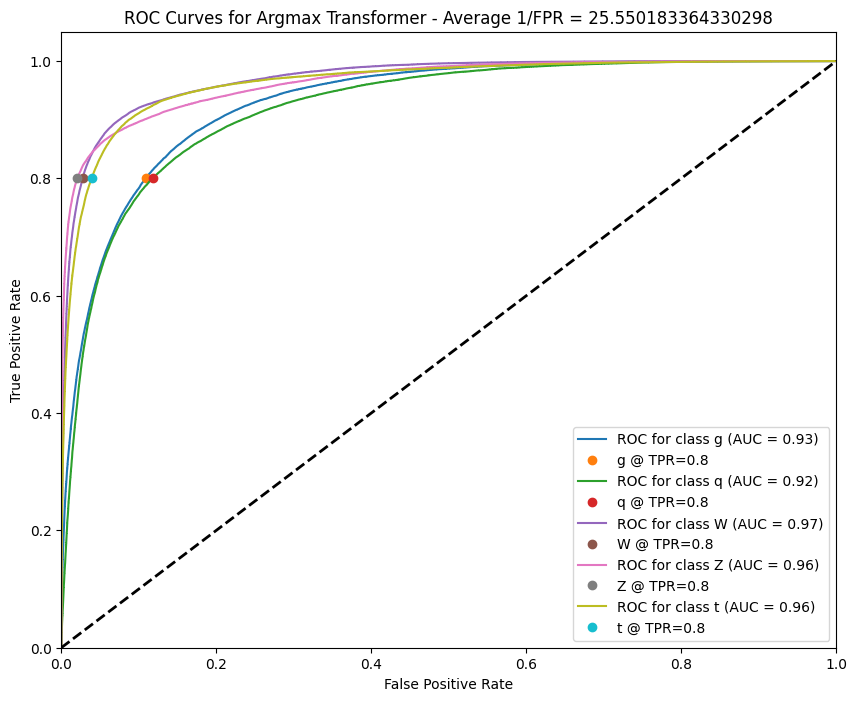

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import tensorflow as tf

# Define your class labels.
class_labels = ['g', 'q', 'W', 'Z', 't']

# Load your validation data.
# (Assuming x_val and y_val are already loaded in your environment)
# Get the model predictions as probabilities.
# If your model outputs logits, you may need to apply softmax first.
y_pred = model(x_val, training=False)

# Convert predictions and labels from TensorFlow tensors to NumPy arrays if needed.
if hasattr(y_pred, "numpy"):
    y_pred = y_pred.numpy()
if hasattr(y_val, "numpy"):
    y_val = y_val.numpy()

# Initialize dictionaries to store false positive rates, true positive rates, AUC, thresholds,
# interpolated FPR at target TPR, and accuracy at that threshold.
fpr = {}
tpr = {}
roc_auc = {}
thresholds_dict = {}
fpr_at_target = {}
accuracy_at_target = {}

# Target true positive rate.
target_tpr = 0.8

# Compute ROC curve, AUC, and interpolate FPR and threshold at target TPR for each class.
for i, label in enumerate(class_labels):
    # Compute ROC curve: returns fpr, tpr, and thresholds.
    fpr[i], tpr[i], thresholds = roc_curve(y_val[:, i], y_pred[:, i])
    thresholds_dict[i] = thresholds  # save thresholds for later use
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Check if the target TPR is reached.
    if target_tpr <= tpr[i][-1]:
        # Interpolate FPR at target TPR.
        fpr_at_target[label] = np.interp(target_tpr, tpr[i], fpr[i])
        # Interpolate threshold at target TPR.
        threshold_at_target = np.interp(target_tpr, tpr[i], thresholds)
        # Compute binary predictions for the current class using the interpolated threshold.
        preds_binary = (y_pred[:, i] >= threshold_at_target).astype(int)
        # Compute accuracy for the current class.
        accuracy = np.mean(preds_binary == y_val[:, i])
        accuracy_at_target[label] = accuracy
    else:
        fpr_at_target[label] = None  # If target TPR is not reached.
        accuracy_at_target[label] = None

# Display the 1/FPR values when TPR=80% for each class.
print("1/FPR at TPR=80% for each class:")
one_over_fpr = []
for label in class_labels:
    if fpr_at_target[label] is not None and fpr_at_target[label] != 0:
        inv_val = 1.0 / fpr_at_target[label]
        one_over_fpr.append(inv_val)
        print(f"{label}: 1/FPR = {inv_val}")
    else:
        print(f"{label}: undefined (FPR is None or zero)")

# Compute and print the average of 1/FPR across classes.
if one_over_fpr:
    avg_one_over_fpr = np.mean(one_over_fpr)
    print(f"Average 1/FPR across classes: {avg_one_over_fpr}")
else:
    print("No valid 1/FPR values to compute an average.")

# Print the accuracy at the FPR corresponding to TPR=80% for each class.
print("\nAccuracy at the threshold corresponding to TPR=80% for each class:")
accuracies = []
for label in class_labels:
    if accuracy_at_target[label] is not None:
        accuracies.append(accuracy_at_target[label])
        print(f"{label}: accuracy = {accuracy_at_target[label]:.4f}")
    else:
        print(f"{label}: accuracy undefined (target TPR not reached)")
if accuracies:
    avg_accuracy = np.mean(accuracies)
    print(f"Average accuracy across classes: {avg_accuracy:.4f}")
else:
    print("No valid accuracy values to compute an average.")

# Plot the ROC curves and mark the point corresponding to TPR=0.8.
plt.figure(figsize=(10, 8))
for i, label in enumerate(class_labels):
    plt.plot(fpr[i], tpr[i], label=f'ROC for class {label} (AUC = {roc_auc[i]:.2f})')
    if fpr_at_target[label] is not None:
        # Mark the point on the ROC curve where TPR = 0.8.
        plt.plot(fpr_at_target[label], target_tpr, 'o', label=f'{label} @ TPR=0.8')

# Plot the random chance line.
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Argmax Transformer - Average 1/FPR = ' + str(avg_one_over_fpr))
plt.legend(loc="lower right")
plt.show()

